In [81]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# To save models
from joblib import load, dump

1.4.1.post1


## Loading the data

In [82]:
# weather data
weather = pd.read_csv('data/weather.csv')
# keep only useful columns
columns = ["timestamp", "temp", "pressure", "cloudiness", "humidity_relative"]
weather = weather[columns]
weather.head()

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8


In [83]:
# sunrise-sunset data
sun = pd.read_excel('data/sunrise-sunset.xlsx')
sun.rename(columns={"datum": "date", "Opkomst": "sunrise", "Op ware middag": "sun_noon", "Ondergang": "sunset"}, inplace=True)
sun.head()

,date,sunrise,sun_noon,sunset
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [84]:
# solar data
solar = pd.read_csv('data/solar.csv')
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,1.02
2,2023-03-11 18:00:10.284064+01,1.17
3,2023-03-11 19:00:10.224836+01,1.18
4,2023-03-11 20:00:10.201847+01,1.18


## Take a quick look at the data structure of every data set

### weather

In [85]:
weather.head()

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8


Observation:
- one row in every four rows in the data set represents the measurements of one weahter station at one timestamp

In [86]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          39840 non-null  object 
 1   temp               39840 non-null  float64
 2   pressure           39828 non-null  float64
 3   cloudiness         15455 non-null  float64
 4   humidity_relative  29880 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.5+ MB


Observation:
- cloudiness and humidity_relative have a lot of null values

In [87]:
weather.describe()

,temp,pressure,cloudiness,humidity_relative
count,39840.000000,39828.000000,15455.000000,29880.000000
mean,11.857083,1013.377732,5.490780,81.043618
std,5.858675,11.320142,2.583189,13.898511
min,-5.900000,965.100000,0.000000,24.700000
25%,8.200000,1007.200000,4.000000,72.500000
50%,11.200000,1014.700000,7.000000,84.200000
75%,15.900000,1021.200000,7.000000,92.000000
max,32.400000,1041.800000,8.000000,100.000000


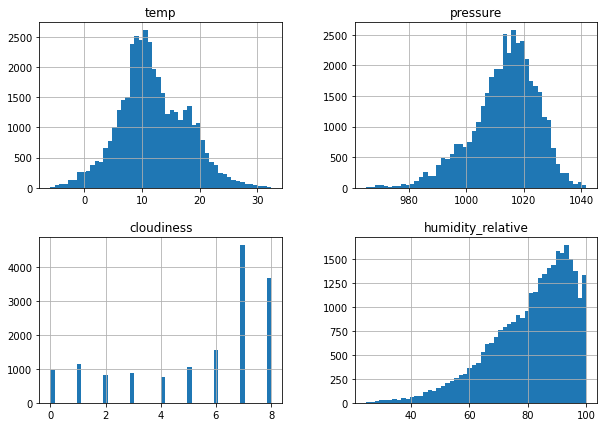

In [88]:
weather.hist(bins=50, figsize=(10,7))
plt.show()

Observations:
- cloudiness is categorical
- humidity_relative looks capped at 100

### solar

In [89]:
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  9705 non-null   object 
 1   kwh        9705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.8+ KB


In [90]:
solar.describe()

,kwh
count,9705.000000
mean,1401.190049
std,741.801205
min,0.000000
25%,772.572600
50%,1737.388200
75%,1964.015800
max,2417.478800


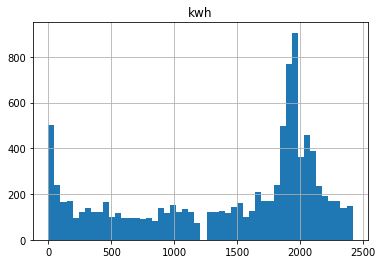

In [91]:
solar.hist(bins=50, figsize=(6, 4))
plt.show()

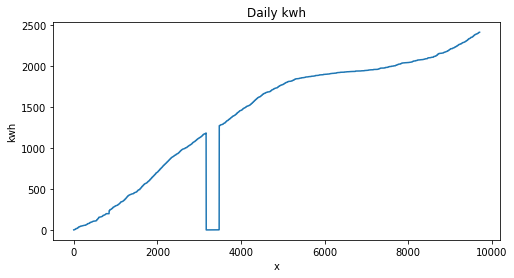

In [92]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(solar["kwh"])
plt.xlabel("x")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

Observations:
- kwh is a cumulative value
- there are outliers

### sunrise-sunset

In [93]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      731 non-null    datetime64[ns]
 1   sunrise   731 non-null    object        
 2   sun_noon  731 non-null    object        
 3   sunset    731 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.0+ KB


In [94]:
sun[["sunrise", "sun_noon", "sunset"]].describe()

,sunrise,sun_noon,sunset
count,731,731,731
unique,195,56,283
top,05:29:00,13:39:00,16:37:00
freq,24,51,20


### merge weahter and solar datasets into one

In [95]:
print(len(weather))
weather = weather.groupby("timestamp").mean().reset_index()
print(len(weather))

39840
9960


In [96]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          9960 non-null   object 
 1   temp               9960 non-null   float64
 2   pressure           9960 non-null   float64
 3   cloudiness         9960 non-null   float64
 4   humidity_relative  9960 non-null   float64
dtypes: float64(4), object(1)
memory usage: 389.2+ KB


In [97]:
# make timestamp datetime64 type
weather["timestamp"] = pd.to_datetime(weather["timestamp"])
solar["timestamp"] = pd.to_datetime(solar["timestamp"].apply(lambda x: x.split(".")[0]))

In [98]:
data = pd.merge_asof(solar, weather, on="timestamp", direction="nearest")
data.shape

(9705, 6)

In [99]:
data.head()

,timestamp,kwh,temp,pressure,cloudiness,humidity_relative
0,2023-03-11 16:00:10,0.54,6.30,1011.625,7.0,57.800000
1,2023-03-11 17:00:10,1.02,5.95,1011.500,7.0,60.366667
2,2023-03-11 18:00:10,1.17,5.25,1011.850,7.0,64.500000
3,2023-03-11 19:00:10,1.18,4.85,1011.650,7.0,68.633333
4,2023-03-11 20:00:10,1.18,4.90,1011.700,7.0,68.400000


In [100]:
# split timestamp into date and hour
data["date"] = data["timestamp"].dt.date.astype("datetime64")
data["hour"] = data["timestamp"].dt.hour
data.drop(columns=["timestamp"], inplace=True)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour
0,0.54,6.30,1011.625,7.0,57.800000,2023-03-11,16
1,1.02,5.95,1011.500,7.0,60.366667,2023-03-11,17
2,1.17,5.25,1011.850,7.0,64.500000,2023-03-11,18
3,1.18,4.85,1011.650,7.0,68.633333,2023-03-11,19
4,1.18,4.90,1011.700,7.0,68.400000,2023-03-11,20


In [101]:
# merge all data
data = data.merge(sun, on=["date"], how="inner")
print(data.shape)

(9705, 10)


In [102]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
1,1.02,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
2,1.17,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
3,1.18,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00
4,1.18,4.90,1011.700,7.0,68.400000,2023-03-11,20,07:06:00,12:53:00,18:40:00


## Cleaning the data

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9705 entries, 0 to 9704
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   kwh                9705 non-null   float64       
 1   temp               9705 non-null   float64       
 2   pressure           9705 non-null   float64       
 3   cloudiness         9705 non-null   float64       
 4   humidity_relative  9705 non-null   float64       
 5   date               9705 non-null   datetime64[ns]
 6   hour               9705 non-null   int64         
 7   sunrise            9705 non-null   object        
 8   sun_noon           9705 non-null   object        
 9   sunset             9705 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 834.0+ KB


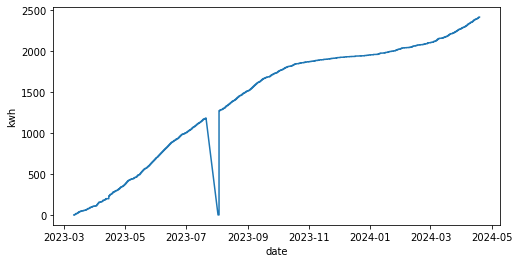

In [104]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(data["date"], data["kwh"])
plt.ylabel("kwh")
plt.xlabel("date")
plt.show()

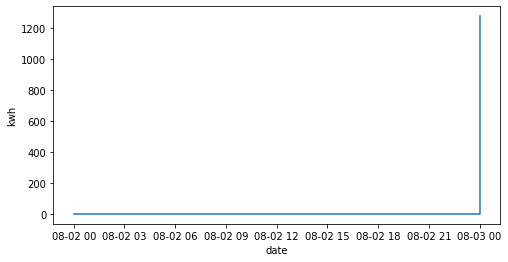

In [105]:
# plot kwh outliers
outliers = data[(data["date"] == "2023-08-02") | (data["date"] == "2023-08-03")]
plt.figure(figsize=(8, 4))
plt.plot(outliers["date"], outliers["kwh"])
plt.xlabel("date")
plt.ylabel("kwh")
plt.show()

In [106]:
# remove outliers
print(data.shape)
data = data[(data["date"] != "2023-08-02") & (data["date"] != "2023-08-03")]
print(data.shape)

(9705, 10)
(9384, 10)


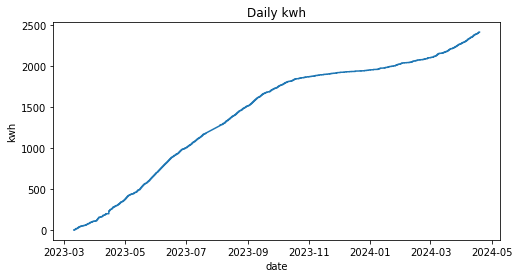

In [107]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(data["date"], data["kwh"])
plt.xlabel("date")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

In [108]:
# kwh is cummulative, make it hourly
data["kwh"] = data["kwh"] - data["kwh"].shift(1, fill_value=0)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
1,0.48,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
2,0.15,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
3,0.01,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00
4,0.00,4.90,1011.700,7.0,68.400000,2023-03-11,20,07:06:00,12:53:00,18:40:00


<Axes: ylabel='kwh'>

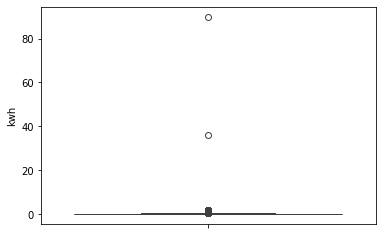

In [109]:
sns.boxplot(data["kwh"])

Observation:
- there are still outliers

In [110]:
def remove_outliers(df, col):
    mean = df[col].mean()
    std = data[col].std()
    return df[abs(df[col] - mean) < 3 * std]

In [111]:
print(data["kwh"].mean(), data["kwh"].std())

0.2576170929241261 1.0943441383011225


In [112]:
print(len(data))
# remove outliers
data = remove_outliers(data, "kwh")
print(len(data))
data.describe()

9384
9382


,kwh,temp,pressure,cloudiness,humidity_relative,hour
count,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000
mean,0.244231,11.855409,1013.800986,5.400927,81.035994,11.573971
std,0.450823,5.696599,11.301160,2.410804,12.772010,6.956335
min,0.000000,-4.650000,967.800000,0.000000,31.366667,0.000000
25%,0.000000,8.250000,1007.750000,3.500000,73.366667,6.000000
50%,0.000000,11.175000,1015.462500,6.500000,84.233333,12.000000
75%,0.248500,15.600000,1021.575000,7.000000,91.100000,18.000000
max,2.098000,30.975000,1041.275000,8.000000,99.033333,23.000000


In [113]:
print(data["kwh"].mean(), data["kwh"].std())

0.244231091451716 0.4508234039274008


<Axes: ylabel='kwh'>

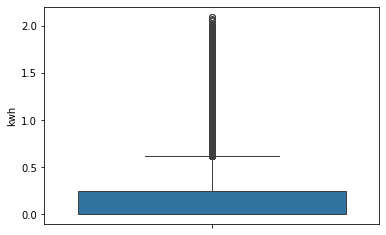

In [114]:
sns.boxplot(data["kwh"])

## Feature Engineering and Extraction

In [115]:
# add light feature
data["after_sunrise"] = data["hour"] >= data["sunrise"].apply(lambda x: x.hour)
data["before_sunset"] = data["hour"] <= data["sunset"].apply(lambda x: x.hour)
data["light"] = data["after_sunrise"] & data["before_sunset"]
data.drop(columns=["after_sunrise", "before_sunset"], inplace=True)
data["light"] = data["light"].astype(int)

In [116]:
# rows where light is 0 and kwh is not 0
len(data[(data["light"] == 0) & (data["kwh"] != 0)])

244

In [117]:
# transform sunrise, sun_noon and sunset to minutes
data["sunrise"] = data["sunrise"].apply(lambda time: time.hour * 60 + time.minute)
data["sun_noon"] = data["sun_noon"].apply(lambda time: time.hour * 60 + time.minute)
data["sunset"] = data["sunset"].apply(lambda time: time.hour * 60 + time.minute)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset,light
0,0.54,6.30,1011.625,7.0,57.800000,2023-03-11,16,426,773,1120,1
1,0.48,5.95,1011.500,7.0,60.366667,2023-03-11,17,426,773,1120,1
2,0.15,5.25,1011.850,7.0,64.500000,2023-03-11,18,426,773,1120,1
3,0.01,4.85,1011.650,7.0,68.633333,2023-03-11,19,426,773,1120,0
4,0.00,4.90,1011.700,7.0,68.400000,2023-03-11,20,426,773,1120,0


In [118]:
# minutes since sunrise at the current hour
data["minutes_since_sunrise"] = data["hour"] * 60 - data["sunrise"]
# minutes from noon at the current hour
data["minutes_from_sun_noon"] = abs(data["hour"] * 60 - data["sun_noon"])
# minutes until sunset at the current hour
data["minutes_until_sunset"] =  data["sunset"] - data["hour"] * 60
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset,light,minutes_since_sunrise,minutes_from_sun_noon,minutes_until_sunset
0,0.54,6.30,1011.625,7.0,57.800000,2023-03-11,16,426,773,1120,1,534,187,160
1,0.48,5.95,1011.500,7.0,60.366667,2023-03-11,17,426,773,1120,1,594,247,100
2,0.15,5.25,1011.850,7.0,64.500000,2023-03-11,18,426,773,1120,1,654,307,40
3,0.01,4.85,1011.650,7.0,68.633333,2023-03-11,19,426,773,1120,0,714,367,-20
4,0.00,4.90,1011.700,7.0,68.400000,2023-03-11,20,426,773,1120,0,774,427,-80


In [119]:
# add month and day columns
data["month"] = data["date"].dt.month
data["day_of_year"] = data["date"].dt.dayofyear
# drop date column
data.drop("date", axis=1, inplace=True)

## Date exploration

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9382 entries, 0 to 9704
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   kwh                    9382 non-null   float64
 1   temp                   9382 non-null   float64
 2   pressure               9382 non-null   float64
 3   cloudiness             9382 non-null   float64
 4   humidity_relative      9382 non-null   float64
 5   hour                   9382 non-null   int64  
 6   sunrise                9382 non-null   int64  
 7   sun_noon               9382 non-null   int64  
 8   sunset                 9382 non-null   int64  
 9   light                  9382 non-null   int32  
 10  minutes_since_sunrise  9382 non-null   int64  
 11  minutes_from_sun_noon  9382 non-null   int64  
 12  minutes_until_sunset   9382 non-null   int64  
 13  month                  9382 non-null   int64  
 14  day_of_year            9382 non-null   int64  
dtypes: f

In [121]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,light,minutes_since_sunrise,minutes_from_sun_noon,minutes_until_sunset,month,day_of_year
0,0.54,6.30,1011.625,7.0,57.800000,16,426,773,1120,1,534,187,160,3,70
1,0.48,5.95,1011.500,7.0,60.366667,17,426,773,1120,1,594,247,100,3,70
2,0.15,5.25,1011.850,7.0,64.500000,18,426,773,1120,1,654,307,40,3,70
3,0.01,4.85,1011.650,7.0,68.633333,19,426,773,1120,0,714,367,-20,3,70
4,0.00,4.90,1011.700,7.0,68.400000,20,426,773,1120,0,774,427,-80,3,70


In [122]:
data.describe()

,kwh,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,light,minutes_since_sunrise,minutes_from_sun_noon,minutes_until_sunset,month,day_of_year
count,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000,9382.00000,9382.000000,9382.000000,9382.000000,9382.000000,9382.000000
mean,0.244231,11.855409,1013.800986,5.400927,81.035994,11.573971,430.622788,797.004477,1163.515775,0.54530,263.815498,369.491793,469.077489,6.185142,172.570987
std,0.450823,5.696599,11.301160,2.410804,12.772010,6.956335,60.719012,28.946012,108.597751,0.49797,421.864564,221.102932,430.864698,3.455836,105.389965
min,0.000000,-4.650000,967.800000,0.000000,31.366667,0.000000,329.000000,746.000000,997.000000,0.00000,-525.000000,3.000000,-383.000000,1.000000,1.000000
25%,0.000000,8.250000,1007.750000,3.500000,73.366667,6.000000,387.000000,771.000000,1059.000000,0.00000,-98.000000,184.000000,106.000000,3.000000,84.000000
50%,0.000000,11.175000,1015.462500,6.500000,84.233333,12.000000,431.000000,812.000000,1161.000000,1.00000,264.000000,365.000000,468.500000,6.000000,156.000000
75%,0.248500,15.600000,1021.575000,7.000000,91.100000,18.000000,484.000000,823.000000,1258.000000,1.00000,626.000000,537.000000,831.000000,9.000000,267.000000
max,2.098000,30.975000,1041.275000,8.000000,99.033333,23.000000,525.000000,829.000000,1320.000000,1.00000,1051.000000,829.000000,1320.000000,12.000000,365.000000


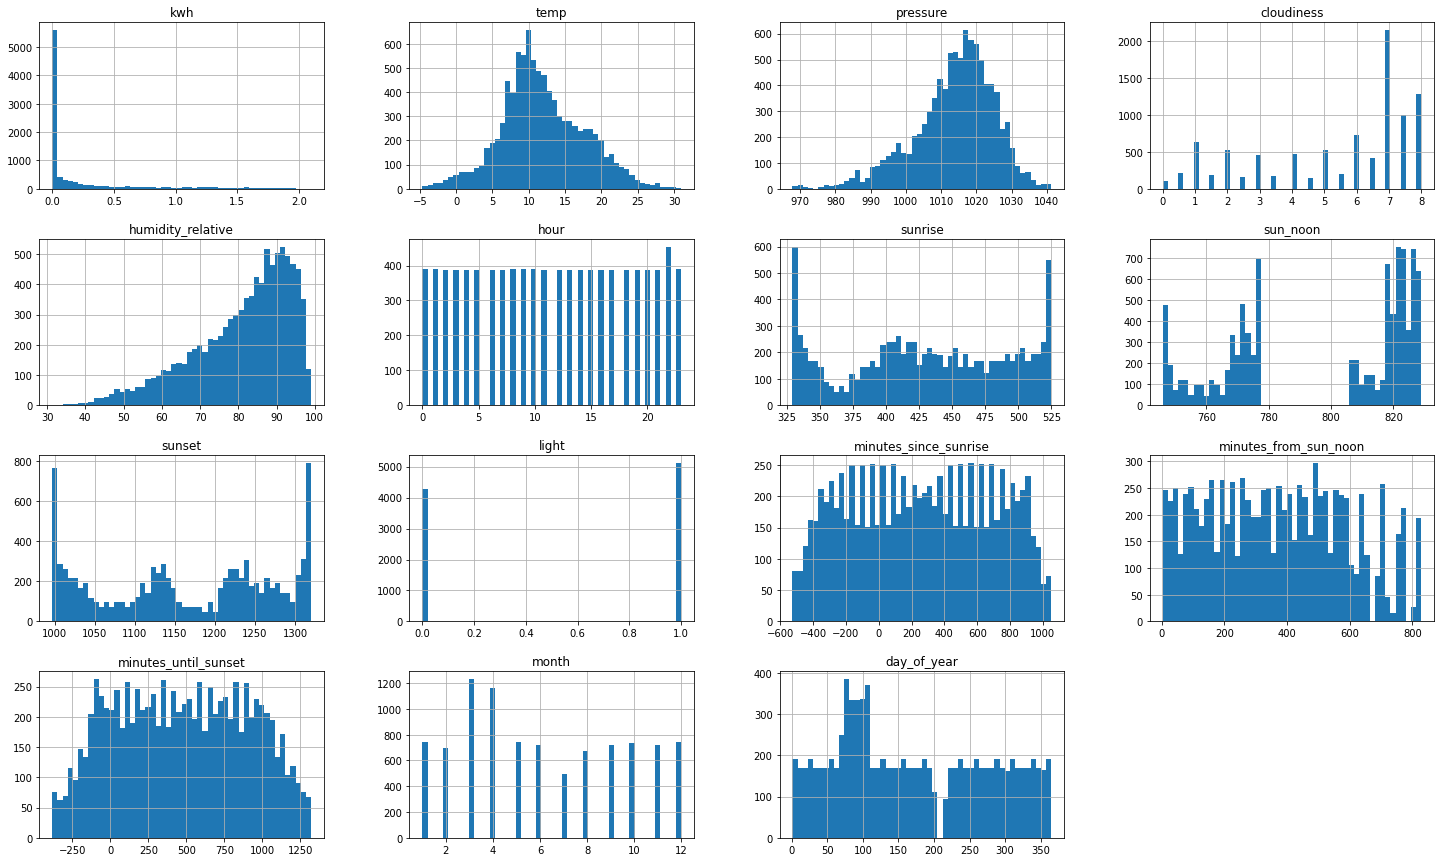

In [123]:
data.hist(bins=50, figsize=(25, 15))
plt.show()

Observations:
- kwh has a lot of 0 values
- month, day, hour and cloudiness are categorical

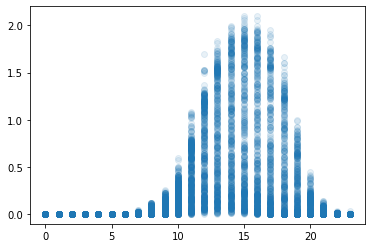

In [124]:
plt.scatter(data["hour"], data["kwh"], alpha=0.1)
plt.show()

Observation:
- kwh is clearly higher during the day

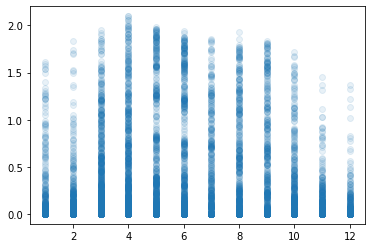

In [125]:
plt.scatter(data["month"], data["kwh"], alpha=0.1)
plt.show()

## Create a test set

In [126]:
X = data.drop(columns=["kwh"])
y = data["kwh"]

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((7505, 14), (1877, 14))

## Look for correlations

In [128]:
data = pd.concat([X_train, y_train], axis=1)

In [129]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kwh"].sort_values(ascending=False).round(2)

kwh                      1.00
light                    0.50
temp                     0.43
sunset                   0.29
minutes_since_sunrise    0.27
sun_noon                 0.26
hour                     0.23
pressure                 0.14
month                   -0.04
day_of_year             -0.04
minutes_until_sunset    -0.15
cloudiness              -0.26
sunrise                 -0.28
minutes_from_sun_noon   -0.60
humidity_relative       -0.68
Name: kwh, dtype: float64

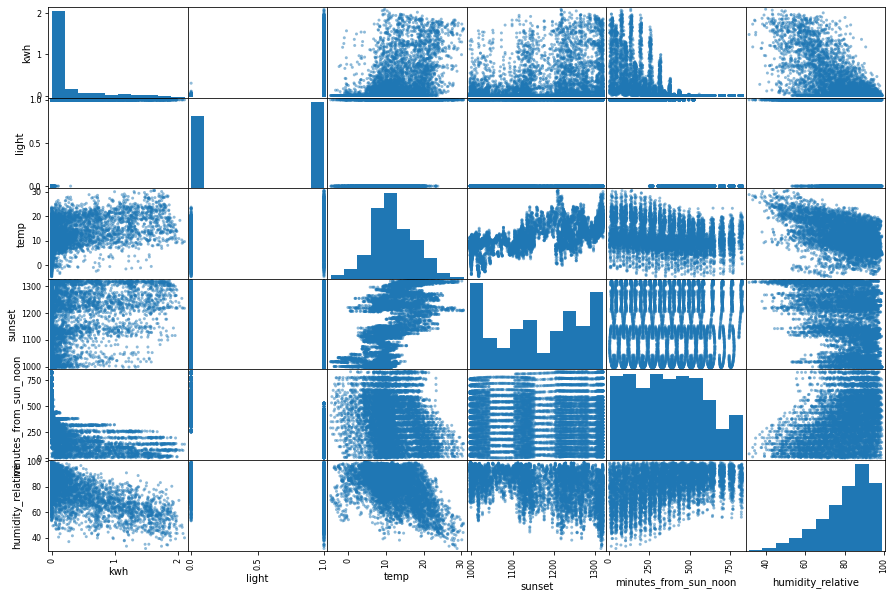

In [130]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "light", "temp", "sunset", "minutes_from_sun_noon", "humidity_relative"]
scatter_matrix(data[attributes], figsize=(15, 10))
plt.show()

## Prepare the data

In [131]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7505 entries, 9043 to 7593
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temp                   7505 non-null   float64
 1   pressure               7505 non-null   float64
 2   cloudiness             7505 non-null   float64
 3   humidity_relative      7505 non-null   float64
 4   hour                   7505 non-null   int64  
 5   sunrise                7505 non-null   int64  
 6   sun_noon               7505 non-null   int64  
 7   sunset                 7505 non-null   int64  
 8   light                  7505 non-null   int32  
 9   minutes_since_sunrise  7505 non-null   int64  
 10  minutes_from_sun_noon  7505 non-null   int64  
 11  minutes_until_sunset   7505 non-null   int64  
 12  month                  7505 non-null   int64  
 13  day_of_year            7505 non-null   int64  
dtypes: float64(4), int32(1), int64(9)
memory usage: 850.2

In [135]:
# give categorical values their own type
X_train["month"] = X_train["month"].astype("category")
# X_train["day_of_year"] = X_train["day_of_year"].astype("category")
X_train["hour"] = X_train["hour"].astype("category")
# X_train["cloudiness"] = X_train["cloudiness"].astype("category")

In [137]:
data_num_ix = X_train.select_dtypes(include=[np.number]).columns
data_cat_ix = X_train.select_dtypes(include=["category"]).columns
print("Numerical columns: ", data_num_ix)
print("Categorical columns: ", data_cat_ix)

Numerical columns:  Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'sunrise',
       'sun_noon', 'sunset', 'light', 'minutes_since_sunrise',
       'minutes_from_sun_noon', 'minutes_until_sunset', 'day_of_year'],
      dtype='object')
Categorical columns:  Index(['hour', 'month'], dtype='object')


In [138]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# log_pipeline = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("log", FunctionTransformer(np.log, inverse_func=np.exp)),
#     ("standardize", StandardScaler())
# ])

cat_pipline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")), 
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, data_num_ix),
    ("cat", cat_pipline, data_cat_ix)
])

## Model selection

### Linear Regression

In [139]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func=np.square)

lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("lin_reg", TransformedTargetRegressor(LinearRegression(), transformer=sqrt_transformer))
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'sunrise',
       'sun_noon', 'sunset', 'light', 'minutes_since_sunrise',
       'minutes_from_sun_noon', 'minutes_until_sunset', 'day_of_year'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['hour', 'month'], dtype='object'))])),
                ('lin_reg',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [140]:
# cross validation for linear regression
from sklearn.model_selection import cross_val_score

scores = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=10)
print("Linear Regression cross validation MAE: ", scores.mean())

Linear Regression cross validation MAE:  0.10400961516104142


In [141]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

y_test_pred = lin_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print("Linear Regression RMSE on test set: ", rmse)
print("Linear Regression MAE on test set: ", mae)

Linear Regression RMSE on test set:  0.19929483954478094
Linear Regression MAE on test set:  0.09926425315287031


In [75]:
y_train_pred = lin_reg.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print("Linear Regression MAE on train set: ", mae)

Linear Regression MAE on train set:  0.10327654893200326


In [76]:
def plot_predictions(y_test, y_pred, size):
    plt.figure(figsize=(12, 6))
    size_range = np.arange(size)
    plt.bar(size_range - 0.2, y_test[:size], 0.4, label="Actual")
    plt.bar(size_range + 0.2, y_pred[:size], 0.4, label="Predicted")
    plt.legend()
    plt.show()

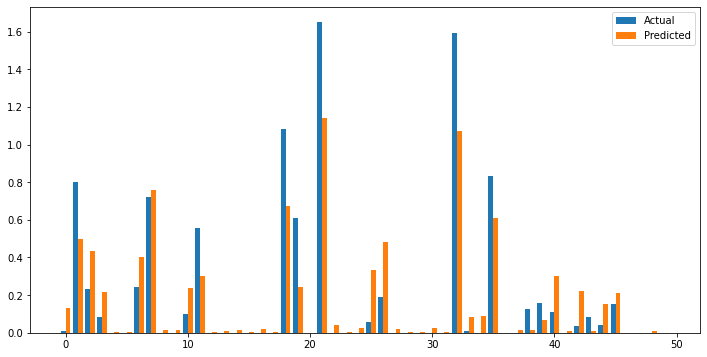

In [77]:
plot_predictions(y_test, y_test_pred, 50)

In [240]:
dump(lin_reg, "models/lin_reg.joblib")

['models/lin_reg.joblib']

In [65]:
# Learning curves

### Polynomial Regression

In [155]:
# Polynomial Regression with different degrees
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone

degrees = range(2, 5)
best_score = np.inf
best_degree = 0
poly_regs = {}

for degree in degrees:
    new_num_pipeline = clone(num_pipeline)
    poly_features = PolynomialFeatures(degree=degree)
    new_num_pipeline.steps.insert(1, ["poly_features", poly_features])
    new_preprocessing = ColumnTransformer([
        ("num", new_num_pipeline, data_num_ix),
        ("cat", cat_pipline, data_cat_ix)
    ])
    poly_reg = Pipeline([
        ("preprocessing", new_preprocessing),
        ("lin_reg", TransformedTargetRegressor(LinearRegression(n_jobs=-1), transformer=sqrt_transformer))
    ])
    scores = -cross_val_score(poly_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
    print(f"Polynomial Regression degree {degree} cross validation MAE: ", scores.mean())
    poly_reg.fit(X_train, y_train)
    print(f"Polynomial Regression degree {degree} test MAE: ", mean_absolute_error(y_test, poly_reg.predict(X_test)))
    poly_regs[f"poly_reg_{degree}"] = poly_reg
    if scores.mean() < best_score:
        best_score = scores.mean()
        best_degree = degree

print("Best degree for polynomial regression: ", best_degree)

Polynomial Regression degree 2 cross validation MAE:  0.08033339793794136
Polynomial Regression degree 2 test MAE:  0.07764990369931736
Polynomial Regression degree 3 cross validation MAE:  0.06913961976720351
Polynomial Regression degree 3 test MAE:  0.06650204560855374
Polynomial Regression degree 4 cross validation MAE:  0.06495690718664178
Polynomial Regression degree 4 test MAE:  0.0632279171054524
Best degree for polynomial regression:  4


In [159]:
poly_reg = poly_regs[f"poly_reg_{best_degree}"]

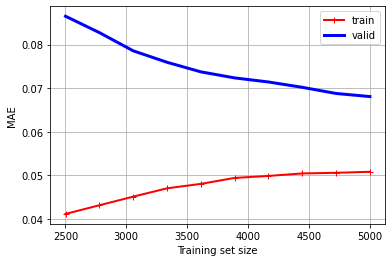

In [162]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    poly_reg, X_train, y_train, train_sizes=np.linspace(0.5, 1.0, 10), cv=3,
    scoring="neg_mean_absolute_error", n_jobs=-1)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

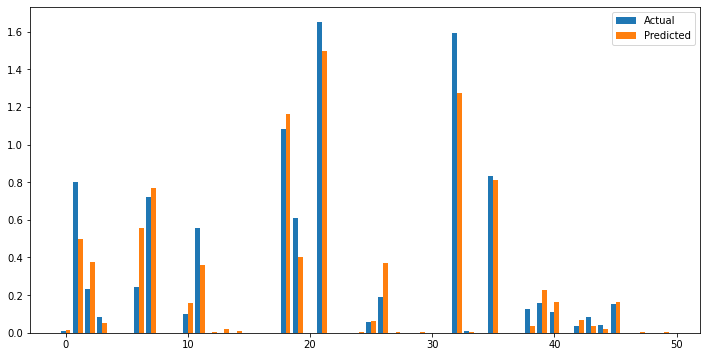

In [157]:
y_test_pred = poly_reg.predict(X_test)
plot_predictions(y_test, y_test_pred, 50)

In [165]:
dump(poly_reg, "models/poly_reg.joblib")

['models/poly_reg.joblib']

### Random Forest

In [150]:
X_train.head()

,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,dark,minutes_since_sunrise,minutes_from_sun_noon,minutes_until_sunset,month
9043,8.650,1014.65,8.0,97.466667,20,400,769,1140,1,800,431,-60,3
5965,11.900,1016.70,4.0,78.000000,11,477,747,1016,0,183,87,356,11
5015,18.900,1023.85,4.0,68.333333,16,470,811,1150,0,490,149,190,10
4099,18.500,1012.85,2.5,63.500000,12,411,824,1235,0,309,104,515,8
2134,21.275,1015.15,1.0,58.600000,15,331,822,1313,0,569,78,413,6


In [147]:
X_train.columns

Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'hour',
       'sunrise', 'sun_noon', 'sunset', 'light', 'minutes_since_sunrise',
       'minutes_from_sun_noon', 'minutes_until_sunset', 'month',
       'day_of_year'],
      dtype='object')

In [166]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True).fit(X_train, y_train)
scores = -cross_val_score(rf, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
print("Random Forest cross validation MAE: ", scores.mean())
mae = mean_absolute_error(y_test, rf.predict(X_test))
print("Random Forest MAE on test set: ", mae)

Random Forest MAE on test set:  0.06053582702894338


In [167]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("forest_reg", RandomForestRegressor(n_jobs=-1, random_state=42))
])
forest_reg.fit(X_train, y_train)
scores = -cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
print("Random Forest cross validation MAE: ", scores.mean())
y_test_pred = forest_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
print("Random Forest MAE on test set: ", mae)

Random Forest cross validation MAE:  0.06577210363207575
Random Forest MAE on test set:  0.06075582631858919


In [168]:
y_train_pred = forest_reg.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print("Random Forest MAE on train set: ", mae)

Random Forest MAE on train set:  0.02402292357772074


In [169]:
from sklearn.model_selection import GridSearchCV

# forest_reg = Pipeline([
#     ("preprocessing", preprocessing),
#     ("forest_reg", RandomForestRegressor(random_state=42, n_jobs=-1))
# ])
forest_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = [
    {
        "n_estimators": [150, 200], 
        "max_features": [8, 11, 14],
        "max_depth": [20, 40, 60],
        "bootstrap": [True, False],
        # "max_samples": [0.5, 0.7, 0.9]
    },
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print("Random Forest best parameters: ", grid_search.best_params_)
print("Random Forest best score: ", -grid_search.best_score_)

Random Forest best parameters:  {'bootstrap': False, 'max_depth': 20, 'max_features': 8, 'n_estimators': 200}
Random Forest best score:  0.06291550179259689


In [175]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,2.456232,0.082988,0.075743,0.006065,False,20,8,200,"{'bootstrap': False, 'max_depth': 20, 'max_fea...",-0.059132,-0.064304,-0.066221,-0.062768,-0.062152,-0.062916,0.002357,1
31,3.233946,0.278334,0.131035,0.019038,False,60,8,200,"{'bootstrap': False, 'max_depth': 60, 'max_fea...",-0.058789,-0.063960,-0.065990,-0.062971,-0.062896,-0.062921,0.002348,2
25,2.468731,0.199832,0.081000,0.007323,False,40,8,200,"{'bootstrap': False, 'max_depth': 40, 'max_fea...",-0.058789,-0.063960,-0.065990,-0.062971,-0.062896,-0.062921,0.002348,2
30,2.027104,0.364234,0.079202,0.020214,False,60,8,150,"{'bootstrap': False, 'max_depth': 60, 'max_fea...",-0.059038,-0.064096,-0.066038,-0.063095,-0.063071,-0.063067,0.002286,4
24,2.071063,0.223062,0.071831,0.011974,False,40,8,150,"{'bootstrap': False, 'max_depth': 40, 'max_fea...",-0.059038,-0.064096,-0.066038,-0.063095,-0.063071,-0.063067,0.002286,4


In [174]:
model = grid_search.best_estimator_
feature_importances = model.feature_importances_
sorted(zip(feature_importances, X_train.columns), reverse=True)

[(0.3545498907638324, 'humidity_relative'),
 (0.25945780471573915, 'minutes_from_sun_noon'),
 (0.07569992798631103, 'minutes_until_sunset'),
 (0.07426849455032647, 'minutes_since_sunrise'),
 (0.0488539306862312, 'hour'),
 (0.04515271470237907, 'cloudiness'),
 (0.03901495663995136, 'light'),
 (0.026195649177622085, 'sunset'),
 (0.02187033362785172, 'pressure'),
 (0.016718383441210374, 'temp'),
 (0.013217438641094988, 'sunrise'),
 (0.011543009835935196, 'day_of_year'),
 (0.011242285367745162, 'sun_noon'),
 (0.002215179863769833, 'month')]

In [177]:
model = grid_search.best_estimator_
y_test_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print("Random Forest RMSE on test set: ", rmse)
print("Random Forest MAE on test set: ", mae)

Random Forest RMSE on test set:  0.13747466071461098
Random Forest MAE on test set:  0.058666649974418936


In [181]:
preds = model.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("Random Forest RMSE on train set: ", mae)

Random Forest RMSE on train set:  0.0007625709279686118


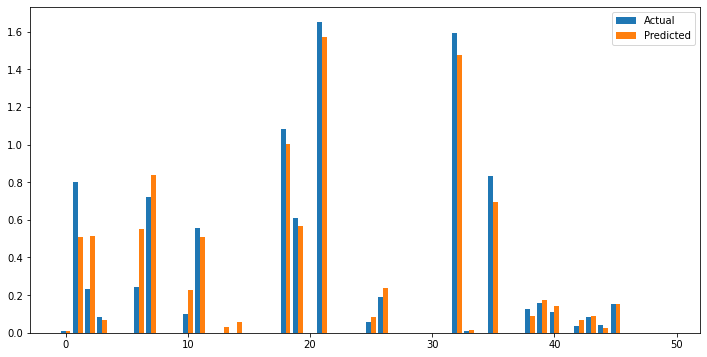

In [179]:
plot_predictions(y_test, y_test_pred, 50)

In [180]:
dump(model, "models/random_forest.joblib")

['models/random_forest.joblib']

### LinearSVR

In [81]:
from sklearn.svm import LinearSVR

svm_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("svm_reg", TransformedTargetRegressor(LinearSVR(random_state=42, dual="auto", max_iter=1000000)))
])

param_grid = [
    {"svm_reg__regressor__C": [0.5, 1, 2], "svm_reg__regressor__epsilon": [0.05, 0.1, 0.5]}
]

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print("SVM best parameters: ", grid_search.best_params_)
print("SVM best MAE score: ", -grid_search.best_score_)

SVM best parameters:  {'svm_reg__regressor__C': 2, 'svm_reg__regressor__epsilon': 0.05}
SVM best MAE score:  0.14755578783965928
